In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mathis as mt
import math

In [2]:
tr = pd.read_csv("datasets/train.csv")
tr_test = pd.read_csv("datasets/test.csv")

tr['training'] = 1
tr_test['training'] = 0
tr_all = tr.append(tr_test)

# Data Cleaning

In [3]:
mt.convert_to_snake_case(tr_all)

In [4]:
tr_all = tr_all.applymap(mt.yes_no_to_bin)

***NaN Cleaning***

In [5]:
{key: val for key, val in tr_all[tr_all['training'] == 1].isna().sum().to_dict().items() if int(val) > 0}

{'lot_frontage': 330,
 'alley': 1911,
 'mas_vnr_type': 22,
 'mas_vnr_area': 22,
 'bsmt_qual': 55,
 'bsmt_cond': 55,
 'bsmt_exposure': 58,
 'bsmt_fin_type_1': 55,
 'bsmt_fin_sf_1': 1,
 'bsmt_fin_type_2': 56,
 'bsmt_fin_sf_2': 1,
 'bsmt_unf_sf': 1,
 'total_bsmt_sf': 1,
 'bsmt_full_bath': 2,
 'bsmt_half_bath': 2,
 'fireplace_qu': 1000,
 'garage_type': 113,
 'garage_yr_blt': 114,
 'garage_finish': 114,
 'garage_cars': 1,
 'garage_area': 1,
 'garage_qual': 114,
 'garage_cond': 114,
 'pool_qc': 2042,
 'fence': 1651,
 'misc_feature': 1986}

- (Above) NaN values to determine if they need to be removed.
- Lot frontage has NaNs that cannot be 0, since all houses have to be connected to the street. It is highly correlated to lot area, which is the lot's square feet. We can make the assumption that all houses are roughly square for the purposes of approximating lot_frontage, as frontage represents one side and thus the root.

In [6]:
mt.corrs_selection(tr_all[tr_all['training'] == 1], 'lot_frontage')

,lot_area
0,0.574024


In [7]:
front = tr_all['lot_frontage'].tolist()
area = tr_all['lot_area'].to_list()

for i in range(0, len(front)):
    if math.isnan(front[i]):
        front[i] = area[i]**.5

tr_all['lot_frontage'] = pd.Series(front)

- Alley is nominal, and NaN values are meaningful in the data dictionary. We will dummy the column.
- Mas Vnr Type is nominal with meaningful NaNs. No removal necessary.
- Mas Vnr Area is always NaN when Mas Vnr Type is. Type being NaN indicates no veneer type, so we will set veneer area to 0.

In [8]:
tr_all['mas_vnr_area'] = tr_all['mas_vnr_area'].map(lambda x: x if not math.isnan(x) else 0)

- Basement sf1, sf2, unf sf, total sf, full bath, and half bath are all continuous data. The only nulls in those values are in rows where bsmt_exposure is NaN, indicating that there is no basement. These values will be set to 0.

In [9]:
tr_all[tr_all['bsmt_full_bath'].isna()][['training', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmt_fin_type_1', 'bsmt_fin_sf_1', 'bsmt_fin_type_2', 'bsmt_fin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'bsmt_full_bath', 'bsmt_half_bath']]

,training,bsmt_qual,bsmt_cond,bsmt_exposure,bsmt_fin_type_1,bsmt_fin_sf_1,bsmt_fin_type_2,bsmt_fin_sf_2,bsmt_unf_sf,total_bsmt_sf,bsmt_full_bath,bsmt_half_bath
616,1,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN
1327,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
basement_nums = ['bsmt_fin_sf_1','bsmt_fin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'bsmt_full_bath', 'bsmt_half_bath']
for col in basement_nums:
    tr_all[col] = tr_all[col].map(lambda x: x if not math.isnan(x) else 0)

- Basement quality, condition, exposure, type1, and type2 are all ordinal values with meaningful NaNs. They will be dummied later.
- Fireplace qu is ordinal with a meaningful NaN.
- Garage cars and garage area are discrete values that are only NaN in a single row. That row has all it's garage ordinal and nominal values indicating that there is no garage except for garage type. We will set cars and area to 0 and type to NaN to be in line with other, similar rows.

In [11]:
tr_all[tr_all['garage_cars'].isna()][['training', 'garage_type', 'garage_yr_blt', 'garage_finish', 'garage_cars', 'garage_area', 'garage_qual', 'garage_cond']]

,training,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond
1712,1,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
tr_all.iloc[1712, tr_all.columns.get_loc('garage_area')] = 0
tr_all.iloc[1712, tr_all.columns.get_loc('garage_cars')] = 0
tr_all.iloc[1712, tr_all.columns.get_loc('garage_type')] = np.NaN

- Garage year built will be an issue later with NaNs as a discrete variable with many values. Setting them to house year built to avoid causing data issues.

In [13]:
year = tr_all['year_built'].tolist()
garage_yr = tr_all['garage_yr_blt'].to_list()

for i in range(0, len(garage_yr)):
    if math.isnan(garage_yr[i]):
        garage_yr[i] = year[i]

tr_all['garage_yr_blt'] = pd.Series(garage_yr)

- Garage type, year built, finish, quality, and condition all have meaningful NaNs that will be dummied later.
- Pool qc, fence, and misc feature also full under this category. There are no more NaNs for us to clean.

In [14]:
{key: val for key, val in tr_all[tr_all['training'] == 1].isna().sum().to_dict().items() if int(val) > 0}

{'alley': 1911,
 'mas_vnr_type': 22,
 'bsmt_qual': 55,
 'bsmt_cond': 55,
 'bsmt_exposure': 58,
 'bsmt_fin_type_1': 55,
 'bsmt_fin_type_2': 56,
 'fireplace_qu': 1000,
 'garage_type': 114,
 'garage_finish': 114,
 'garage_qual': 114,
 'garage_cond': 114,
 'pool_qc': 2042,
 'fence': 1651,
 'misc_feature': 1986}

***Outlier cleaning***

- Note: for additional visuals, see pairplot.png in this repository, created at this step.

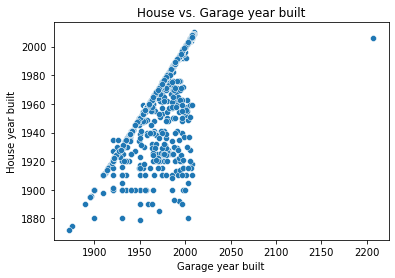

In [15]:
sns.scatterplot(data = tr_all[tr_all['training'] == 1], x = 'garage_yr_blt', y = 'year_built')
plt.xlabel("Garage year built")
plt.ylabel("House year built")
plt.title("House vs. Garage year built")
plt.show()

- Outlier identified in garage year built via visual analysis. Appears to be clerical error, correcting 2207 to 2007.

In [16]:
pd.set_option('display.max_columns', None)
tr_all[(tr_all['training'] == 1) & (tr_all['garage_yr_blt'] > 2100)][['year_built', 'garage_yr_blt']]

,year_built,garage_yr_blt
1699,2006,2207.0


In [17]:
tr_all.iloc[1699, tr_all.columns.get_loc('garage_yr_blt')] = 2007

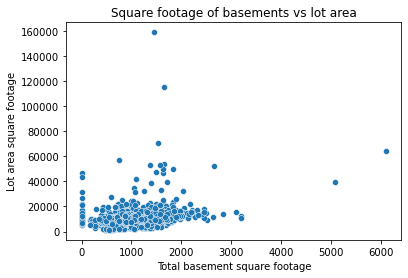

In [18]:
sns.scatterplot(data = tr_all[tr_all['training'] == 1], x = 'total_bsmt_sf', y = 'lot_area')
plt.xlabel("Total basement square footage")
plt.ylabel("Lot area square footage")
plt.title("Square footage of basements vs lot area")
plt.show()

- Basement outliers with high basement sf to lot area ratio deemed to be within the realm of possiblity when compared to other high basement sf data. No removal required.

In [19]:
tr_all[(tr_all['training'] == 1)]['total_bsmt_sf'].quantile(.99)

2216.5

In [20]:
tr_all[(tr_all['training'] == 1) & (tr_all['total_bsmt_sf'] > 2216)][['lot_area', 'total_bsmt_sf']].sort_values(by = 'total_bsmt_sf', ascending = False).T

,960,1885,1147,328,1164,1227,1964,1117,30,623,786,685,1647,1058,199,1671,800,1158,378,480,1248
lot_area,63887.0,39290.0,10655.0,12692.0,15431.0,14300.0,51974.0,11400.0,9600.0,14836.0,17778.0,11128.0,15274.0,13693.0,13472.0,12919.0,17169.0,11778.0,13651.0,14082.0,15865.0
total_bsmt_sf,6110.0,5095.0,3206.0,3200.0,3094.0,2846.0,2660.0,2633.0,2524.0,2492.0,2461.0,2458.0,2452.0,2418.0,2392.0,2330.0,2320.0,2271.0,2223.0,2220.0,2217.0


- Moving on to outliers with |z_score| > 3. Among outliers below, none were deemed to be due to clerical error or beyond the realm of possibility.

In [21]:
irrelevant = ['ms_sub_class', 'overall_qual', 'overall_cond', 'central_air', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abv_gr', 'kitchen_abv_gr', 'tot_rms_abv_grd', 'fireplaces', 'garage_cars']
for key, val in mt.outlier_dict(tr_all[tr_all['training'] == 1]).items():
    if not key in irrelevant:
        print(f'{key}, {val}\n')

lot_frontage, [174.0, 180.17491501316158, 180.74291134094304, 195.0, 198.45402490249472, 200.0, 217.43964679883013, 223.83476048192335, 230.44956064180292, 230.70977439198367, 239.16521486202797, 313.0, 313.0, 339.3361165570208, 398.74804074753774]

lot_area, [31250, 31770, 32463, 32668, 33120, 34650, 39104, 39290, 39384, 41600, 43500, 46589, 47007, 47280, 50102, 50271, 51974, 53107, 53227, 53504, 57200, 63887, 70761, 115149, 159000]

year_built, [1872, 1875, 1879, 1880, 1880, 1880]

mas_vnr_area, [630.0, 632.0, 640.0, 647.0, 650.0, 650.0, 651.0, 652.0, 660.0, 660.0, 662.0, 664.0, 668.0, 673.0, 674.0, 692.0, 705.0, 710.0, 714.0, 724.0, 730.0, 731.0, 734.0, 738.0, 748.0, 760.0, 766.0, 772.0, 796.0, 816.0, 860.0, 886.0, 894.0, 902.0, 922.0, 945.0, 970.0, 1031.0, 1047.0, 1050.0, 1095.0, 1110.0, 1115.0, 1129.0, 1224.0, 1600.0]

bsmt_fin_sf_1, [1880.0, 1904.0, 1972.0, 2085.0, 2146.0, 2158.0, 2188.0, 4010.0, 5644.0]

bsmt_fin_sf_2, [546.0, 547.0, 551.0, 551.0, 555.0, 557.0, 580.0, 590.0, 590

***Save files***

In [22]:
train = tr_all[tr_all['training'] == 1]
test = tr_all[tr_all['training'] == 0]

train.to_csv("datasets/modified_train.csv")
test.to_csv("datasets/modified_test.csv")

***To step 2***